In [202]:
import numpy as np
from random import uniform, randint, sample
import matplotlib.pyplot as plt
import tensorflow as tf

import keras


### 1. Epsilon-Greedy

In [445]:
class Coin(object):
    def __init__(self, p):
        self.p = p 
        
    def sample(self):
        if uniform(0, 1) < self.p:
            return 1 
        return 0 

In [446]:
# assuming cur_mean is the avg 
# over (n - 1) elements
def update_mean(cur_mean, cur_value, n):
    if n == 1:
        return cur_value
    return (cur_mean * (n - 1) + cur_value) / float(n)

In [451]:
class EpsilonGreedyAgent(object):
    def __init__(self, epsilon):
        self.epsilon = epsilon 
        self.avg_rewards = np.zeros(2)
        self.counts = np.zeros(2)
        self.prev_ac = None 
        self.agent_type_str = "epsilon greedy"
        
    def run(self, prior_reward, t):
        if prior_reward is not None:
            assert self.prev_ac is not None 
            self.avg_rewards[self.prev_ac] = update_mean(self.avg_rewards[self.prev_ac],
                                                         prior_reward,
                                                         self.counts[self.prev_ac])
        ac = np.argmax(self.avg_rewards)
        if uniform(0, 1) <= self.epsilon:
            ac = 1 - ac # swap; ac \in {0, 1}
        self.prev_ac = ac 
        self.counts[ac] += 1
        return ac 
    
    def reset(self):
        self.avg_rewards = np.zeros(2)
        self.counts = np.zeros(2)
        self.prev_ac = None 

In [452]:
class UCBAgent(object):
    def __init__(self):
        self.avg_rewards = np.zeros(2)
        self.counts = np.zeros(2)
        self.prev_ac = None 
        self.agent_type_str = "UCB"
        
    def run(self, prior_reward, t):
        if prior_reward is not None:
            assert self.prev_ac is not None 
            self.avg_rewards[self.prev_ac] = update_mean(self.avg_rewards[self.prev_ac],
                                                         prior_reward,
                                                         self.counts[self.prev_ac])
        freq_term = np.sqrt(2 * np.log(t) / self.counts)
        ucb_values = self.avg_rewards + freq_term
        ac = np.argmax(ucb_values)
        self.prev_ac = ac 
        self.counts[ac] += 1
        return ac 
        
    def reset(self):
        self.avg_rewards = np.zeros(2)
        self.counts = np.zeros(2)
        self.prev_ac = None 
        return ac 

In [484]:
def run_bandit(agent, 
               coin1_p, coin2_p,
               num_trials = 40, 
               num_runs = 1000):
    coins = [Coin(coin1_p), Coin(coin2_p)]
    all_rewards = []
    for _ in range(num_trials):
        rewards, reward = [], None
        agent.reset()
        for t in range(num_runs):
            ac = agent.run(reward, t + 1)
            assert ac in [0, 1]
            reward = coins[ac].sample()
            rewards.append(reward)
        all_rewards.append(rewards)
    final_rewards = np.mean(all_rewards, 0)
    
    plt.plot(np.cumsum(final_rewards))
    plt.ylim(0, 1050)
    plt.grid(num_runs * 1.05)
    plt.yticks([0, np.sum(final_rewards), num_runs])
    
    plt.xlabel("t")
    plt.ylabel("accumulative reward")
    title_str = "Two-coin betting game (T = 1000) \n coin1_p: {}, coin2_p: {} \n agent type: {}".format(coin1_p, coin2_p, agent.agent_type_str) 
    if agent.agent_type_str == 'epsilon greedy':
        title_str += "\nepsilon = {}".format(agent.epsilon)
    plt.title(title_str)
    
    

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide


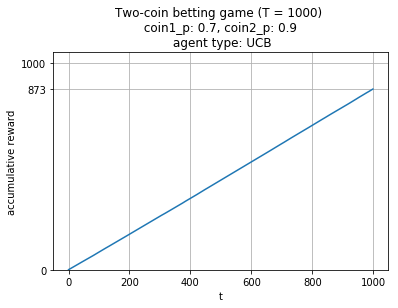

In [486]:
agent = UCBAgent()
run_bandit(agent, 0.7, 0.9)



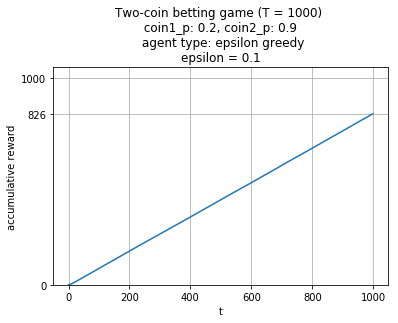

In [497]:
agent = EpsilonGreedyAgent(0.1)
run_bandit(agent, 0.2, 0.9)



### 2. Linear Search 

In [307]:
def f(x):
    return pow(x, 4)

def f_d(x):
    return 4 * pow(x, 3)

def f_d_d(x):
    return 12 * pow(x, 2)


In [308]:
class SteepestDescentAgent(object):        
    def get_direction(self, x):
        return - 1. * f_d(x)

In [309]:
class NewtonAgent(object):
    def get_direction(self, x):
        return - 1. * f_d(x) / float(f_d_d(x))
    

In [327]:
print_type = {SteepestDescentAgent: "steepest descent",
              NewtonAgent: "newton"}
def train(agentType, lr, 
          N = 100, epsilon = None, 
          verbose = True, 
          if_opt_step = False):
    assert agentType in [SteepestDescentAgent, NewtonAgent]
    agent = agentType() 
    
    x, step_size, i_epsilon = 1., 1., None
    values = [f(x)]
    for i in range(N):
        if if_opt_step:
            step_size = x / float(f_d(x))
        if epsilon is not None and f(x) < epsilon and i_epsilon is None:
            i_epsilon = i
        x += agent.get_direction(x) * lr * step_size
        values.append(f(x))
    if verbose:
        plt.plot(values)
        plt.yticks([1, min(values)])
        plt.xticks([0, N, i_epsilon] if i_epsilon is not None else [0, N])
        plt.xlabel("t")
        plt.ylabel("function value")
        title_str = "Agent: {} \n learning rate: {}".format(print_type[agentType], lr) 
        if if_opt_step: 
            title_str += "\n with optimal step-size"
        plt.title(title_str)
        plt.grid()
    return f(x)


0.0001413590882476063

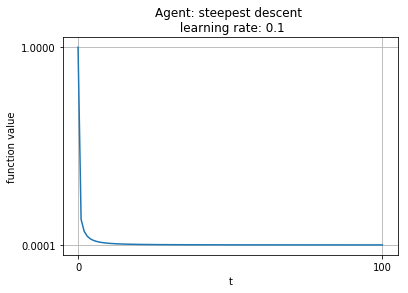

In [328]:
train(SteepestDescentAgent, 0.1)


0.011984543028368077

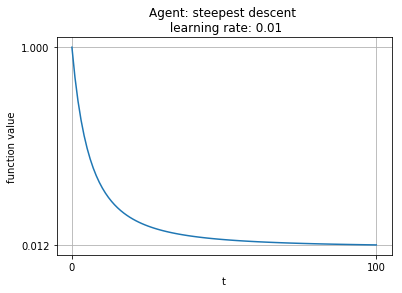

In [329]:
train(SteepestDescentAgent, 0.01)


0.0001413590882476063

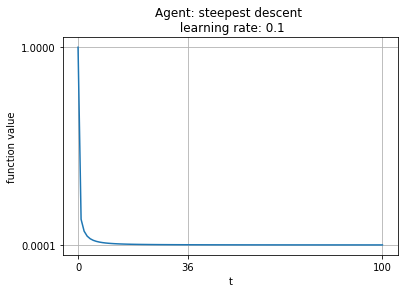

In [330]:
train(SteepestDescentAgent, 0.1, epsilon = 0.001)


4.977414122938479e-19

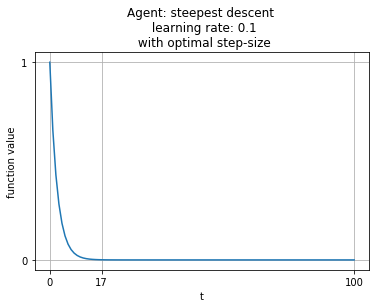

In [331]:
train(SteepestDescentAgent, 0.1, epsilon = 0.001, if_opt_step = True)


1.290319532988043e-06

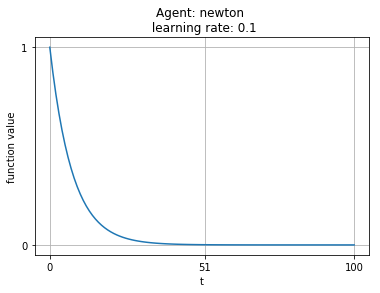

In [318]:
train(NewtonAgent, 0.1, epsilon = 0.001)


### 3. Linear Search with RL

#### Descrete 


In [401]:
descrete_states = [round(x, 2) for x in np.arange(0, 1.001, 0.01)]
x2state_map = dict(zip(descrete_states, np.arange(0, len(descrete_states))))

def get_state_id(x):
    return x2state_map[round(x, 2)]

descrete_actions = [1., 2., 3., 4., 5.]

def get_reward(x):
    return 1. - pow(x, 4)

print("Discrete state space size: {}".format(len(descrete_states)))
print("Discrete action space size: {}".format(len(descrete_actions)))


Discrete state space size: 101
Discrete action space size: 5


In [402]:
def descrete_Q_learning(lr, alpha, gamma,
                        num_iter_per_train = 100,
                        eps = 0.1, eps_converge = 0.0001):
    Q = {}
    descent_agent = SteepestDescentAgent()
    
    def pick_action(s):
        if uniform(0, 1) < eps:
            return randint(0, len(descrete_actions))
        Qs = [Q.get((s, ac), 0.) for ac in descrete_actions]
        if np.all([q == 0. for q in Qs]):
            return randint(0, len(descrete_actions))
        return descrete_actions[int(np.argmax(Qs))]
        
    prev_q_value_per_entry = None 
    i = 0
    while True:
        i += 1
        if i % 20 == 0:
            print ("iter {} ".format(i))
        x = 1.
        s = get_state_id(x)
        for _ in range(num_iter_per_train):
            ac = pick_action(s)
            next_x = x + descent_agent.get_direction(x) * lr * ac
            next_s = get_state_id(next_x)
            next_Qs = [Q.get((next_s, ac_), 0.) for ac_ in descrete_actions]
            r = get_reward(x)
            Q[(s, ac)] = Q.get((s, ac), 0.) + alpha * (r + gamma * max(next_Qs) - Q.get((s, ac), 0.))
            x = next_x
            s = next_s
        q_value_per_entry = sum(Q.values()) / float(len(Q))
        if prev_q_value_per_entry is not None and abs(q_value_per_entry - prev_q_value_per_entry) < eps_converge:
            break;
        prev_q_value_per_entry = q_value_per_entry
    return Q 


In [406]:
Q = descrete_Q_learning(0.01, .8, .95)


iter 20 
iter 40 
iter 60 
iter 80 
iter 100 
iter 120 
iter 140 
iter 160 
iter 180 
iter 200 
iter 220 
iter 240 
iter 260 
iter 280 


0.0012171185690863266


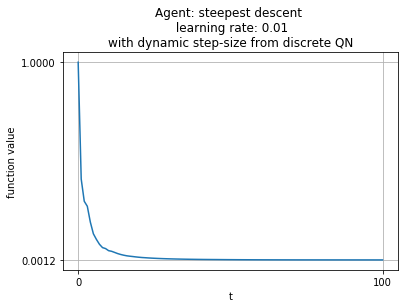

In [407]:
agent = SteepestDescentAgent() 

x = 1.
lr = 0.01

values = [f(x)]
step_sizes = []
for i in range(100):
    s = get_state_id(x)
    Qs = [Q.get((s, ac), 0.) for ac in descrete_actions]
    if np.all([q == 0. for q in Qs]):
        step_size = 1. 
    else:
        step_size = descrete_actions[np.argmax(Qs)] 
    x += agent.get_direction(x) * lr * step_size 
    values.append(f(x))
    step_sizes.append(step_size)

print (f(x))
plt.plot(values)
plt.yticks([1, min(values)])
plt.xticks([0, 100])
plt.xlabel("t")
plt.ylabel("function value")
title_str = "Agent: {} \n learning rate: {}".format(print_type[SteepestDescentAgent], lr) 
title_str += "\nwith dynamic step-size from discrete QN"
plt.title(title_str)
plt.grid()


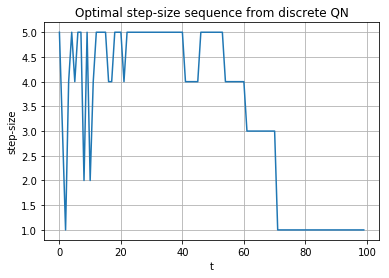

In [408]:
plt.plot(step_sizes)
# plt.yticks([1., 2.])
# plt.xticks([0, 100])
plt.xlabel("t")
plt.ylabel("step-size")
plt.title("Optimal step-size sequence from discrete QN")
plt.grid()



#### Continuous - DDPG


In [286]:
tf.reset_default_graph()
state_dim = 4 # [x, f(x), f_d(x), f_d_d(x)]
ac_dim = 1 


In [293]:
class Actor(object):
    def __init__(self, sess, 
                 lr = 1e-4,
                 tau = 0.01):
        self.sess = sess 
        self.tau = tau
        self.lr = lr
        self._create_models()
        self._create_training()
        self.sess.run(tf.initialize_all_variables())
        self.update_target_network()
        
    def _create_models(self):
        self.state_ph = tf.placeholder(shape = [None, state_dim], dtype = tf.float32)
        W = tf.Variable(tf.random_uniform([state_dim, ac_dim], 0, 0.01))
        b = tf.Variable(tf.random_uniform([ac_dim], 0, 0.01))
        self.weights = [W, b]
        self.ac_output = (tf.tanh(tf.matmul(self.state_ph, W) + b) + tf.constant(1.)) * tf.constant(2.5) # step size \in (0, 5)
        
        self.target_state_ph = tf.placeholder(shape = [None, state_dim], dtype = tf.float32)
        MAagent = tf.train.ExponentialMovingAverage(decay = 1 - self.tau)
        self.target_update = MAagent.apply(self.weights)
        target_W, target_b = MAagent.average(W), MAagent.average(b)
        self.target_ac_output = (tf.tanh(tf.matmul(self.target_state_ph, target_W) + target_b) + tf.constant(1.)) * tf.constant(2.5) # step size \in (0, 5)
        
    def _create_training(self):
        self.gradient_ph = tf.placeholder(shape = [None, ac_dim], dtype = tf.float32)
        grads = tf.gradients(self.ac_output, self.weights, - self.gradient_ph)
        self.train_op = tf.train.AdamOptimizer(self.lr).apply_gradients(zip(grads, self.weights))
        
    def update_target_network(self):
        self.sess.run(self.target_update)
        
    def get_action(self, state):
        return self.sess.run(self.ac_output, feed_dict = {self.state_ph: state})
    
    def get_target_action(self, state):
        return self.sess.run(self.target_ac_output, feed_dict = {self.target_state_ph: state})
    
    def train(self, gradient, state):
        self.sess.run(self.train_op, 
                      feed_dict = {self.gradient_ph: gradient,
                                   self.state_ph: state})



In [294]:
class Critic(object):
    def __init__(self, sess, 
                 lr = 1e-4, 
                 tau = 0.01):
        self.sess = sess 
        self.tau = tau
        self.lr = lr
        self._create_models()
        self._create_training()
        self.sess.run(tf.initialize_all_variables())
        self.update_target_network()
        
    def _create_models(self):
        self.state_ph = tf.placeholder(shape = [None, state_dim], dtype = tf.float32)
        self.ac_ph = tf.placeholder(shape = [None, ac_dim], dtype = tf.float32)
        all_ph = tf.concat([self.state_ph, self.ac_ph], 1)
        W = tf.Variable(tf.random_uniform([state_dim + ac_dim, 1], 0, 0.01))
        b = tf.Variable(tf.random_uniform([1], 0, 0.01))
        self.weights = [W, b]
        self.q_output = tf.matmul(all_ph, W) + b
        
        self.target_state_ph = tf.placeholder(shape = [None, state_dim], dtype = tf.float32)
        self.target_ac_ph = tf.placeholder(shape = [None, ac_dim], dtype = tf.float32)
        all_ph = tf.concat([self.target_state_ph, self.target_ac_ph], 1)
        MAagent = tf.train.ExponentialMovingAverage(decay = 1 - self.tau)
        self.target_update = MAagent.apply(self.weights)
        target_W, target_b = MAagent.average(W), MAagent.average(b)
        self.target_q_output = tf.matmul(all_ph, target_W) + target_b
        
    def _create_training(self):
        self.y_ph = tf.placeholder(shape = [None, 1], dtype = tf.float32)
        loss = tf.reduce_mean(tf.square(self.y_ph - self.q_output))
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)
        self.ac_gradient = tf.gradients(self.q_output, self.ac_ph)
        
    def update_target_network(self):
        self.sess.run(self.target_update)
        
    def get_target_q(self, state, ac):
        return self.sess.run(self.target_q_output, feed_dict = {self.target_state_ph: state, self.target_ac_ph: ac})
    
    def get_gradient(self, state, ac):
        return self.sess.run(self.ac_gradient, 
                             feed_dict = {self.state_ph: state,
                                          self.ac_ph: ac})
    
    def train(self, y, state, ac):
        self.sess.run(self.train_op, 
                      feed_dict = {self.y_ph: y, self.state_ph: state, self.ac_ph: ac})

In [295]:
class ReplayBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size 
        self.buffer = []
        
    def get_batch(self, batch_size):
        return sample(self.buffer, batch_size)
    
    def add(self, state, action, reward, next_state):
        self.buffer.append([state, action, reward, next_state])
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0) # pop the oldest
            
    def get_size(self):
        return len(self.buffer)
        

In [296]:
class DDPG(object):
    def __init__(self, 
                 gamma = .99, 
                 buffer_size = None, 
                 batch_size = None):
        self.sess = tf.Session()
        self.actor = Actor(self.sess)
        self.critic = Critic(self.sess)
        
        self.replay_buffer = None
        if buffer_size is not None:
            self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.start_buffer_size = 2 * self.batch_size if self.batch_size is not None else None 
                
        self.gamma = gamma
        
    def get_action(self, state):
        assert len(state.shape) == 2 and state.shape[1] == state_dim 
        return self.actor.get_action(state)
    
    def train(self, state, action, reward, next_state):
        state_ = state 
        action_ = action 
        reward_ = reward 
        next_state_ = next_state
        if self.replay_buffer is not None:
            self.replay_buffer.add(state, action, reward, next_state)
            if self.replay_buffer.get_size() <= self.start_buffer_size:
                 return 
            assert self.batch_size is not None 
            batches = self.replay_buffer.get_batch(self.batch_size)
            state_ = np.squeeze([x[0] for x in batches], axis = 1)
            action_ = np.squeeze([x[1] for x in batches], axis = 1).reshape([-1, ac_dim])
            reward_ = np.squeeze([x[2] for x in batches], axis = 1).reshape([-1, 1])
            next_state_ = np.squeeze([x[3] for x in batches], 1)
        next_ac = self.actor.get_target_action(next_state_)
        next_q = self.critic.get_target_q(next_state_, next_ac)

        q = self.critic.get_target_q(next_state_, next_ac)
        y = reward + self.gamma * next_q
        self.critic.train(y, state_, action_)

        ac = self.actor.get_action(state_)
        grad = self.critic.get_gradient(state_, ac)[0]
        self.actor.train(grad, state_)

        self.critic.update_target_network()
        self.actor.update_target_network()

In [297]:
def get_state(x):
    a = np.array([[x, f(x), f_d(x), f_d_d(x)]])
    return np.array([[x, f(x), f_d(x), f_d_d(x)]])

def get_reward_DDPG(x):
    return [[1. - pow(x, 4)]]


In [424]:
lr = .01 
num_iter_per_train = 100
descent_agent = SteepestDescentAgent() 
DDPG_agent = DDPG()

for i in range(100):  
    if (i + 1)  % 20 == 0:
        print ("iter {}".format(i + 1))
    x = 1.
    for _ in range(num_iter_per_train):
        ac = DDPG_agent.get_action(get_state(x))
        ac_raw = ac[0][0]
        next_x = x + descent_agent.get_direction(x) * lr * ac_raw 
        DDPG_agent.train(get_state(x), ac, get_reward_DDPG(x), get_state(next_x))
        x = next_x 


iter 20
iter 40
iter 60
iter 80
iter 100


0.0005920599342846846


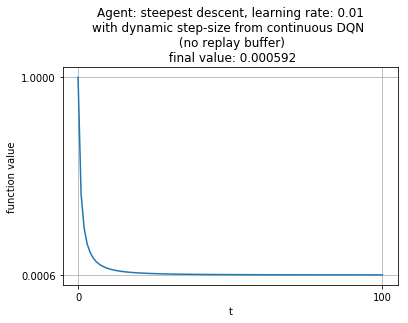

In [436]:
agent = SteepestDescentAgent() 

x = 1.
lr = 0.01

values = [f(x)]
step_sizes = []
for i in range(100):
    step_size = ac = DDPG_agent.get_action(get_state(x))
    x += agent.get_direction(x) * lr * step_size[0][0]
    values.append(f(x))
    step_sizes.append(step_size[0][0])

print (f(x))
plt.plot(values)
plt.yticks([1, min(values)])
plt.xticks([0, 100])
plt.xlabel("t")
plt.ylabel("function value")
title_str = "Agent: {}, learning rate: {}".format(print_type[SteepestDescentAgent], lr) 
title_str += "\nwith dynamic step-size from continuous DQN \n (no replay buffer)"
title_str += "\n final value: {:.6f}".format(values[-1])
plt.title(title_str)
plt.grid()


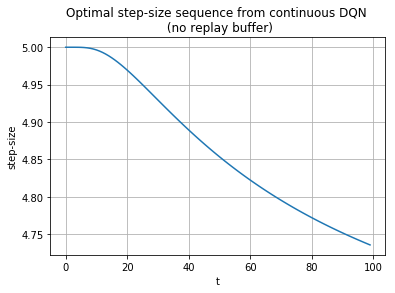

In [437]:
plt.plot(step_sizes)
# plt.yticks([1., 2.])
# plt.xticks([0, 100])
plt.xlabel("t")
plt.ylabel("step-size")
plt.title("Optimal step-size sequence from continuous DQN \n (no replay buffer)")
plt.grid()



In [438]:
lr = .01 
num_iter_per_train = 200
# descent_agent = SteepestDescentAgent() 
DDPG_agent = DDPG(buffer_size = 10000, batch_size = 64)
# DDPG_agent = DDPG()

for i in range(100):  
    if (i + 1)  % 20 == 0:
        print ("iter {}".format(i + 1))
    x = 1.
    for _ in range(num_iter_per_train):
        ac = DDPG_agent.get_action(get_state(x))
        ac_raw = ac[0][0]
        next_x = x + descent_agent.get_direction(x) * lr * ac_raw 
        DDPG_agent.train(get_state(x), ac, get_reward_DDPG(x), get_state(next_x))
        x = next_x 


iter 20
iter 40
iter 60
iter 80
iter 100


0.0005633945303002734


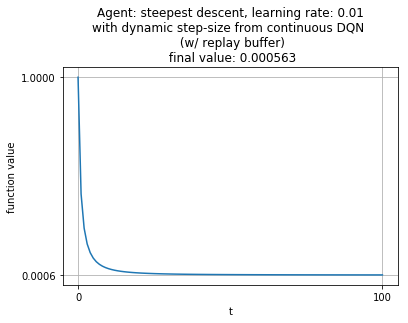

In [441]:
agent = SteepestDescentAgent() 

x = 1.
lr = 0.01

values = [f(x)]
step_sizes = []
for i in range(100):
    step_size = ac = DDPG_agent.get_action(get_state(x))
    x += agent.get_direction(x) * lr * step_size[0][0]
    values.append(f(x))
    step_sizes.append(step_size[0][0])

print (f(x))
plt.plot(values)
plt.yticks([1, min(values)])
plt.xticks([0, 100])
plt.xlabel("t")
plt.ylabel("function value")
title_str = "Agent: {}, learning rate: {}".format(print_type[SteepestDescentAgent], lr) 
title_str += "\nwith dynamic step-size from continuous DQN \n (w/ replay buffer)"
title_str += "\n final value: {:.6f}".format(values[-1])
plt.title(title_str)
plt.grid()


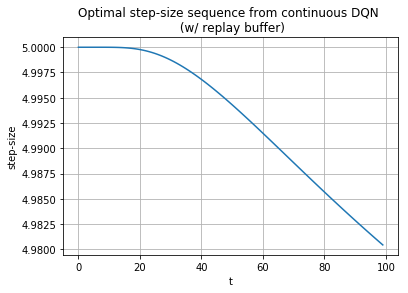

In [442]:
plt.plot(step_sizes)
# plt.yticks([1., 2.])
# plt.xticks([0, 100])
plt.xlabel("t")
plt.ylabel("step-size")
plt.title("Optimal step-size sequence from continuous DQN \n (w/ replay buffer)")
plt.grid()

0.0005618634425065279


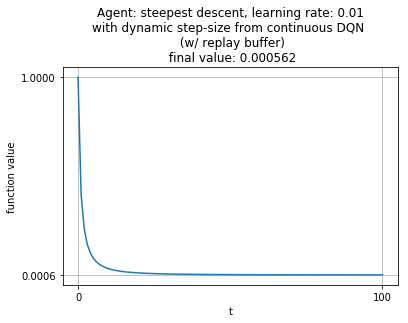

In [444]:
agent = SteepestDescentAgent() 

x = 1.
lr = 0.01

values = [f(x)]
step_sizes = []
for i in range(100):
    step_size = ac = DDPG_agent.get_action(get_state(x))
    x += agent.get_direction(x) * lr * 5.
    values.append(f(x))
    step_sizes.append(step_size[0][0])

print (f(x))
plt.plot(values)
plt.yticks([1, min(values)])
plt.xticks([0, 100])
plt.xlabel("t")
plt.ylabel("function value")
title_str = "Agent: {}, learning rate: {}".format(print_type[SteepestDescentAgent], lr) 
title_str += "\nwith dynamic step-size from continuous DQN \n (w/ replay buffer)"
title_str += "\n final value: {:.6f}".format(values[-1])
plt.title(title_str)
plt.grid()
